In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import timeit

# Загрузка данных
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
full_data = pd.concat([train_data, test_data])

train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Преобразование меток в числовые значения
le = LabelEncoder()
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')
train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
# Определение датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [5]:
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
# Определение модели RNN
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return out

100%|██████████| 89/89 [00:00<00:00, 783.88it/s]


Epoch 1, Train Loss: 3.2268604332259287, Val Loss: 1.3979938345009022


100%|██████████| 89/89 [00:00<00:00, 1057.78it/s]


Epoch 2, Train Loss: 0.7086537347172542, Val Loss: 0.3464587233709485


100%|██████████| 89/89 [00:00<00:00, 1020.48it/s]


Epoch 3, Train Loss: 0.2306415381981192, Val Loss: 0.18894316528118058


100%|██████████| 89/89 [00:00<00:00, 1008.62it/s]


Epoch 4, Train Loss: 0.1436674663369615, Val Loss: 0.1481124106376024


100%|██████████| 89/89 [00:00<00:00, 979.14it/s]


Epoch 5, Train Loss: 0.11645478458689901, Val Loss: 0.13466794553390715


100%|██████████| 89/89 [00:00<00:00, 831.34it/s]


Epoch 6, Train Loss: 0.10322560430385658, Val Loss: 0.12986115935478318


100%|██████████| 89/89 [00:00<00:00, 1033.91it/s]


Epoch 7, Train Loss: 0.09763921149702949, Val Loss: 0.12508290517928727


100%|██████████| 89/89 [00:00<00:00, 997.58it/s]


Epoch 8, Train Loss: 0.0938337094291633, Val Loss: 0.12252072533958833


100%|██████████| 89/89 [00:00<00:00, 1048.63it/s]


Epoch 9, Train Loss: 0.09106381192259891, Val Loss: 0.12088390957731544


100%|██████████| 89/89 [00:00<00:00, 1029.18it/s]


Epoch 10, Train Loss: 0.08961758723913853, Val Loss: 0.12149738662698295


100%|██████████| 89/89 [00:00<00:00, 1012.62it/s]


Epoch 11, Train Loss: 0.08820182963494717, Val Loss: 0.12230999618925656


100%|██████████| 89/89 [00:00<00:00, 1006.65it/s]


Epoch 12, Train Loss: 0.08765979153572426, Val Loss: 0.12219946886663942


100%|██████████| 89/89 [00:00<00:00, 1009.18it/s]


Epoch 13, Train Loss: 0.0869919439601625, Val Loss: 0.1260961432172132


100%|██████████| 89/89 [00:00<00:00, 1049.06it/s]


Epoch 14, Train Loss: 0.08604215623028628, Val Loss: 0.12557922812895536


100%|██████████| 89/89 [00:00<00:00, 1009.30it/s]


Epoch 15, Train Loss: 0.08552006150499546, Val Loss: 0.12664703384703654


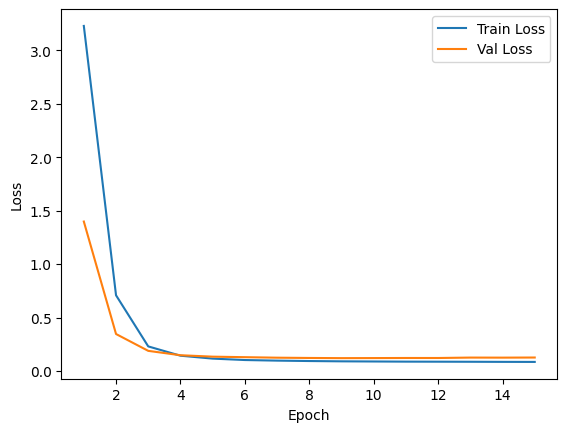

In [7]:
# Инициализация модели
model = RNNClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_losses = []
val_losses = []

for epoch in range(15):
    train_loss = 0
    val_loss = 0

    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, 16), train_losses, label='Train Loss')
plt.plot(range(1, 16), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.float().to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.1166 seconds
Average time per response: 0.000041 seconds
0.953210404586831
(0.9492666846259229, 0.9511158342189161, 0.9481863457943894, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
